In [1]:
import retinapy.mea as mea
import numpy as np
import pandas as pd
import json
from collections import defaultdict
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots
import sklearn.decomposition as skd
from sklearn.decomposition import PCA

In [2]:
# Load recording
rec_name = 'Chicken_17_08_21_Phase_00'
#rec_name = "Chicken_06_08_21_2nd_Phase_00"
rec = mea.single_3brain_recording(
    rec_name,
    mea.load_stimulus_pattern('../data/ff_noise.h5'),
    mea.load_recorded_stimulus('../data/ff_recorded_noise.pickle'),
    mea.load_response('../data/ff_spike_response.pickle'))
print(rec)

Recording: Chicken_17_08_21_Phase_00, sensor sample rate: 17852.76785 Hz, num samples: 16071532, duration: 900.2 seconds, stimulus pattern shape: (24000, 4),num clusters: 154.


In [3]:
downsample, snippet_len, snippet_pad = (180, 120, 20)
zoom = (1000 * downsample) / mea.ELECTRODE_FREQ

In [4]:
snippets, cluster_ids, sample_rate = mea.labeled_spike_snippets(rec,
                                      snippet_len,
                                      snippet_pad,
                                      downsample=downsample)

In [5]:
by_cluster = defaultdict(list)
for idx in range(len(cluster_ids)):
    by_cluster[cluster_ids[idx]].append(snippets[idx])

In [6]:
colormap = pd.DataFrame({
    'names':['Red', 'Green', 'UV', 'Blue', 'Stim'],
    'display_hex':['#ff0a0a', '#0aff0a', '#0a0aff', '#303030', '#0a0a0a']})
def kernel_plot(kernel, snippet_len, snippet_pad):
    fig = go.Figure()
    # Move the zero point to the left, visually.
    zero_offset = zoom * (snippet_len - snippet_pad)
    xs = zoom * np.arange(kernel.shape[0]) - zero_offset
    # Shift the x-axis to have zero in the middle.
    #xs -= zoom * xs.shape[0] // 2
    for c in range(4):
        fig.add_trace(go.Scatter(x=xs, 
                                 y=kernel[:,c], 
                                 line_color=colormap.loc[c]['display_hex'], 
                                 mode='lines'))
    fig.add_vline(x=-100, line_width=2, line_dash='dot', line_color='grey',
                  annotation_text='-100ms', annotation_position='bottom right')
    fig.update_layout(autosize=False,
                      height=500,
                      width=600,
                      margin=dict(l=1, r=1, b=1, t=25, pad=1),
                      yaxis_fixedrange=True,
                      showlegend=False,
                      title='Kernel',
                      title_x=0.5,
                      title_pad=dict(l=1, r=1, b=10, t=1),
                      xaxis={'title':'time (ms), with spike at 0'},
                      yaxis={'title':'summed responses'} )
    return fig

def spike_rate_plot(spikes, win_sec=10):
    num_bins = int(experiment_duration_secs / win_sec)
    spike_times = spikes / electrode_freq
    fig = px.histogram(spike_times, nbins=num_bins)
    fig.update_layout(autosize=False,
                      height=300,
                      width=800,
                      margin=dict(l=1, r=1, b=1, t=25, pad=1),
                      showlegend=False,
                      title=f'Spike counts ({win_sec} sec bins)', 
                      title_pad=dict(l=1, r=1, b=10, t=1),
                      title_x=0.5,
                      yaxis_fixedrange=True)
    return fig

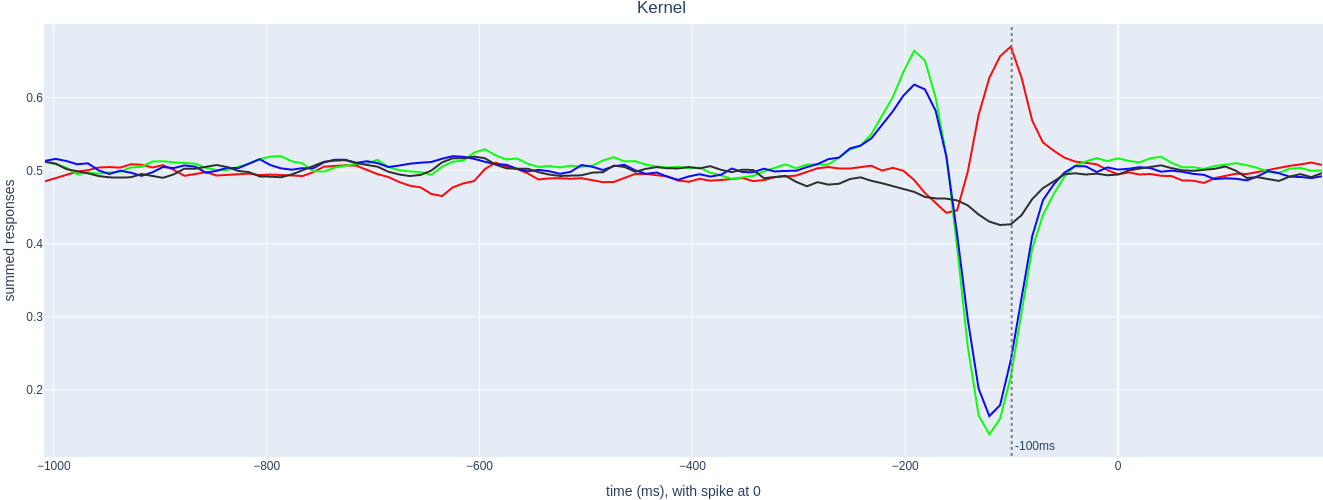

In [8]:
sid_list = [21]#[664] #+ list(by_cluster.keys())[0:10]
for sid in sid_list:
    snippets = by_cluster[sid]
    var = np.var(snippets, axis=0)
    ave = np.mean(snippets, axis=0)
    p = kernel_plot(ave, snippet_len, snippet_pad)
    p.show()
    
